# Colour - Checker Detection - Examples: Segmentation

This notebook showcases segmentation retated colour checker detection examples.

<div class="alert alert-info">
The original *.CR2 files were processed with <em>dcraw</em> as follows: <code>dcraw -T -g 2.4 12.92 *.CR2</code> and then resized and converted to *.png with <em>Image Magick</em> as follows: <code>mogrify -resize 50% -format png *.tiff</code>.
</div>

In [1]:
import glob
import os
import colour
import numpy as np

from colour_checker_detection import (
    ROOT_RESOURCES_EXAMPLES,
    detect_colour_checkers_segmentation,
)

colour.plotting.colour_style()

colour.utilities.describe_environment();

*                                                                             *
*   Interpreter :                                                             *
*       python : 3.11.13 (main, Jun  4 2025, 08:57:30) [GCC 13.3.0]           *
*                                                                             *
*   colour-science.org :                                                      *
*       colour : 0.4.6                                                        *
*       colour-checker-detection : 0.2.1                                      *
*                                                                             *
*   Runtime :                                                                 *
*       imageio : 2.37.0                                                      *
*       matplotlib : 3.10.6                                                   *
*       networkx : 3.5                                                        *
*       numpy : 2.2.6                   

## Images

In [2]:
COLOUR_CHECKER_IMAGE_PATHS = glob.glob(
    os.path.join(ROOT_RESOURCES_EXAMPLES, "detection", "*19*.png")
)

path_dir="/home/girobat/Olive/foto olivo del  07.08.24/da01c0"
#path_dir="/home/girobat/Olive/foto olivo del  07.08.24/foto 11.09.24 olivo università"
#path_dir="/home/girobat/Olive/foto olivo del  07.08.24/foto olivo 28.08.24"
COLOUR_CHECKER_IMAGE_PATHS = glob.glob(
    os.path.join(path_dir, '*.jpg'))

COLOUR_CHECKER_IMAGES = [
    colour.cctf_decoding(colour.io.read_image(path))
    for path in COLOUR_CHECKER_IMAGE_PATHS
]

/home/girobat/Olive/venv_311/lib/python3.11/site-packages/colour/utilities/verbose.py:322: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)  # noqa: B028


## Detection

✅ Loaded 7 valid colour checker detections.
⚠️ 0 images without detected colour checker.


IntSlider(value=0, description='Page:', max=1)

Output()

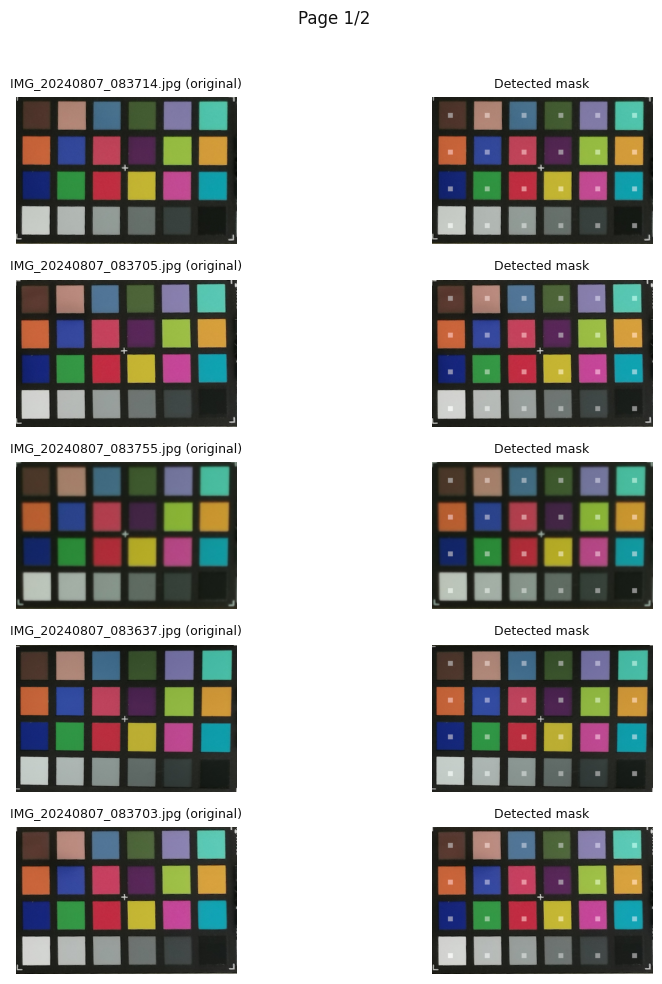

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import colour
%matplotlib inline
import ipywidgets as widgets
from IPython.display import display, clear_output

# your existing function
from colour_checker_detection import detect_colour_checkers_segmentation

# --- build data list ---
DATA = []
NO_COLOUR_CHECKERS_PATH =[]
for img, path in zip(COLOUR_CHECKER_IMAGES, COLOUR_CHECKER_IMAGE_PATHS):
    detected = list(detect_colour_checkers_segmentation(img, additional_data=True))
    if not detected:
        print(f"⚠️ No colour checker detected in: {path}")
        NO_COLOUR_CHECKERS_PATH.append(path)
        continue

    # If multiple found, take first
    swatch_colours, swatch_masks, colour_checker_image, quadrilateral = detected[0].values

    masks_i = np.zeros(colour_checker_image.shape)
    for mask in swatch_masks:
        masks_i[mask[0]:mask[1], mask[2]:mask[3], ...] = 1

    # Apply visible mask overlay
    mask_overlay = np.clip(colour_checker_image + masks_i * 0.25, 0, 1)
    DATA.append((colour_checker_image, mask_overlay, os.path.basename(path)))

print(f"✅ Loaded {len(DATA)} valid colour checker detections.")
print(f"⚠️ {len(NO_COLOUR_CHECKERS_PATH)} images without detected colour checker.")

# --- parameters ---
IMAGES_PER_PAGE = 5

# --- function to show a page ---
def show_page(page):
    plt.close('all')  # close old figure to avoid stacking outputs
    start = page * IMAGES_PER_PAGE
    end = start + IMAGES_PER_PAGE
    subset = DATA[start:end]
    n = len(subset)

    fig, axes = plt.subplots(n, 2, figsize=(10, 2 * n))
    if n == 1:
        axes = np.array([axes])  # ensure iterable

    for i, (orig, mask, name) in enumerate(subset):
        # left: original
        ax1 = axes[i, 0]
        ax1.imshow(colour.cctf_encoding(np.clip(orig, 0, 1)))
        ax1.set_title(f"{name} (original)", fontsize=9)
        ax1.axis("off")

        # right: mask
        ax2 = axes[i, 1]
        ax2.imshow(colour.cctf_encoding(np.clip(mask, 0, 1)))
        ax2.set_title("Detected mask", fontsize=9)
        ax2.axis("off")

    fig.suptitle(f"Page {page+1}/{(len(DATA)-1)//IMAGES_PER_PAGE + 1}", fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- create slider for navigation ---
page_slider = widgets.IntSlider(
    min=0, 
    max=(len(DATA)-1)//IMAGES_PER_PAGE, 
    step=1, 
    value=0,
    description='Page:'
)
output = widgets.Output()

def update_page(change):
    with output:
        clear_output(wait=True)
        show_page(change['new'])

page_slider.observe(update_page, names='value')

display(page_slider, output)
show_page(0)


# Images where colour checker is NOT detected

### create a folder of NOT detected images inside the main folder

In [4]:
import os
import shutil

if NO_COLOUR_CHECKERS_PATH!=[]:
    # Save paths to a text file
    with open(f"{path_dir}/file_paths.txt", "w") as f:
        for path in NO_COLOUR_CHECKERS_PATH:
            f.write(path + "\n")

    print("✅ Paths saved to file_paths.txt")

    # Directory where to save not-detected images
    NOT_DETECTED_DIR = os.path.join(path_dir, "not_detected_images")
    os.makedirs(NOT_DETECTED_DIR, exist_ok=True)

    # Get the list of paths of detected images
    detected_paths = [os.path.join(path_dir, name) for _, _, name in DATA]

    # Find images that were not detected
    not_detected_paths = [p for p in COLOUR_CHECKER_IMAGE_PATHS if os.path.basename(p) not in [os.path.basename(d) for d in detected_paths]]

    # Copy them to the new folder
    for path in not_detected_paths:
        if os.path.isfile(path):
            shutil.copy2(path, NOT_DETECTED_DIR)  # copy2 preserves timestamps
            print(f"Copied not-detected: {path}")
        else:
            print(f"⚠️ File not found: {path}")

    print(f"✅ {len(not_detected_paths)} not-detected images copied to {NOT_DETECTED_DIR}")
else:
    print("✅ All images had detected colour checkers. No files copied.")


✅ Paths saved to file_paths.txt
Copied not-detected: /home/girobat/Olive/foto olivo del  07.08.24/foto olivo 28.08.24/IMG_20240828_090634.jpg
Copied not-detected: /home/girobat/Olive/foto olivo del  07.08.24/foto olivo 28.08.24/IMG_20240828_090644.jpg
Copied not-detected: /home/girobat/Olive/foto olivo del  07.08.24/foto olivo 28.08.24/IMG_20240828_090633.jpg
Copied not-detected: /home/girobat/Olive/foto olivo del  07.08.24/foto olivo 28.08.24/IMG_20240828_095725.jpg
Copied not-detected: /home/girobat/Olive/foto olivo del  07.08.24/foto olivo 28.08.24/IMG_20240828_095702.jpg
Copied not-detected: /home/girobat/Olive/foto olivo del  07.08.24/foto olivo 28.08.24/IMG_20240828_085739.jpg
✅ 6 not-detected images copied to /home/girobat/Olive/foto olivo del  07.08.24/foto olivo 28.08.24/not_detected_images
